# Interpretable Machine Learning: PD8

In [336]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

## Definiowanie potrzebnych funkcji

In [434]:
def rec(competitors: list, y: pd.Series, no_points: int, xmax: float=None):
    dfs = []
    for _, model, X in competitors:
        df = X.assign(
            y = y,
            preds = model.predict(X)
        )
        # Maximum absolute residual
        max_abs_resid = max(abs(df.y - df.preds))
        df = pd.concat([df] * no_points)
        df = df.assign(
            thresholds = np.repeat(np.linspace(0, max_abs_resid, no_points), X.shape[0])
        )
        df = df.assign(
            in_thresh = (df.y - df.preds).abs() <= df['thresholds'].values
        )

        dfs.append(df.groupby('thresholds').agg({'in_thresh':'mean'}))
    # Plot REC
    args = sum([[df.reset_index()['thresholds'], df.reset_index()['in_thresh']] for df in dfs], [])
    plt.plot(*args)
    if xmax:
        plt.xlim(0, xmax)
    plt.xlabel('Error tolerance')
    plt.ylabel('Accuracy')
    names = list(map(list, zip(*competitors)))[0]
    plt.legend(names, loc='lower right')
    plt.show()

In [427]:
a = [(1,2,3), (3,4,5), (5,6,7)]

In [433]:
list(map(list, zip(*a)))

[[1, 3, 5], [2, 4, 6], [3, 5, 7]]

In [407]:
def pdp_and_pelt(model, var, X, no_points, rpt_pen, subplot=None):
    # Prepare dataframe for PDP prediction, predict and aggregate
    df = pd.concat([X] * no_points)
    df[var] = np.repeat(np.linspace(X[var].min(), X[var].max(), no_points), X.shape[0])
    df['preds'] = model.predict(df)
    df = df.groupby(var).agg({'preds':'mean'})
    
    # Plot PDP
    if subplot != None:
        plt.subplot(*subplot)
    plt.plot(df, 'grey')
    
    # Change point detection
    algo = rpt.Pelt(model="rbf").fit(df)
    df = df.reset_index() 
    breaks = df.iloc[algo.predict(pen=rpt_pen)[:-1], 0].tolist() # Last element must be left out
    for b in breaks:
        plt.axvline(b, ls='--')
    breaks = [X[var].min() - 1e-5] + breaks + [X[var].max()] # Epsilon to include leftmost edge
    
    # Final elements of the plot
    plt.xlabel(var)
    plt.ylabel('Bikes count')
    if not subplot:
        plt.show()
    return breaks

In [391]:
def safe_clust(model, var, X, n_clusters):
    # Prepare dataframe for imputation, predict and aggregate
    df = pd.concat([X] * X[var].nunique())
    df[var] = np.repeat(X[var].unique(), X.shape[0])
    df = df.assign(
        preds = model.predict(df)
    )
    df = df.groupby(var).agg({'preds':'mean'})
            
    # Clustering the aggregated data
    cl = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = cl.fit_predict(df)
    return dict(zip(df.index.to_list(), map(str, clusters)))

Dane pochodzą z [openml.org](https://www.openml.org/d/1414). Wybrany zbiór to zmodyfikowana wersja konkursu na Kaggle: [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/). Celem jest przewidzenie popytu na rowery w danym dniu, w zależności od pogody i typu dnia (weekend, święto itd.).

In [37]:
data = pd.read_csv('https://www.openml.org/data/get_csv/1796712/php6pI1Nq')

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['datetime', 'time', 'count'], axis=1), 
                                                    data['count'], test_size=0.2)

In [46]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,dayOfWeek
6449,'1','0','1','1',9.02,9.090,37,390.007,'zondag'
7687,'2','0','0','1',30.34,32.575,30,70.015,'maandag'
3585,'3','0','1','2',27.06,30.305,83,60.032,'dinsdag'
7705,'2','0','1','2',27.06,30.305,78,190.012,'woensdag'
6634,'1','0','1','1',28.70,31.820,37,70.015,'woensdag'


## Eksploracja danych

In [54]:
numeric_vars = [i for i, dt in enumerate(X_train.dtypes) if dt == np.float64 or dt == np.int64]
categorical_vars = [i for i in range(X_train.shape[1]) if i not in numeric_vars]

In [56]:
print(numeric_vars, categorical_vars)

[4, 5, 6, 7] [0, 1, 2, 3, 8]


Dla zmiennych ciągłych rysuję wykresy rozrzutu wraz z dopasowanymi prostymi regresji.

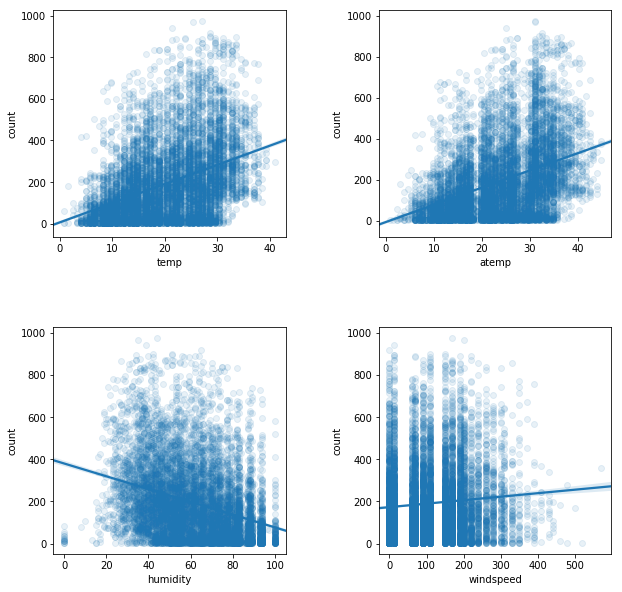

In [79]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, var in enumerate(numeric_vars):
    ax = fig.add_subplot(2, 2, i+1)
    sns.regplot(X_train.iloc[:, var], y_train, scatter_kws={'alpha':0.1})
plt.show()

Dla każdej ze zmiennych widać monotoniczną zależność. Dla zmiennych kategorycznych używam wykresów skrzypcowych.

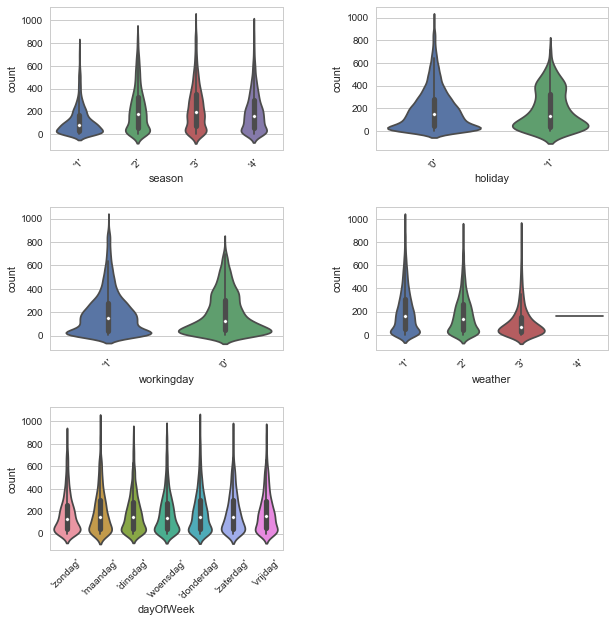

In [93]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, var in enumerate(categorical_vars):
    ax = fig.add_subplot(3, 2, i+1)
    sns.violinplot(x=X_train.columns[var], y=y_train, data=X_train)
    plt.xticks(rotation=45)
plt.show()

Rozkład zmiennej celu jest mocno skośny, również w rozbiciu względem zmiennych kategorycznych. Najciekawsze obserwacje to znacząco inny rozkład dla pory roku równej '1' (pewnie zima, bo mniej rowerów pożyczonych). Dla dni nieroboczych i świąt widać "zgrubienie" ok. 400, które może odpowiadać dniom, kiedy więcej osób zdecydowało się na rekreacyjną przejażdżkę.

In [94]:
for var in categorical_vars:
    print(X_train.iloc[:, var].value_counts())

'2'    2202
'4'    2191
'3'    2184
'1'    2131
Name: season, dtype: int64
'0'    8464
'1'     244
Name: holiday, dtype: int64
'1'    5918
'0'    2790
Name: workingday, dtype: int64
'1'    5752
'2'    2279
'3'     676
'4'       1
Name: weather, dtype: int64
'dinsdag'      1314
'vrijdag'      1304
'woensdag'     1265
'zondag'       1248
'donderdag'    1228
'zaterdag'     1221
'maandag'      1128
Name: dayOfWeek, dtype: int64


Pogoda o poziomie '4' zdarzyła się tylko raz. Więcej niż 2 kategorie mają tylko 3 zmienne i tylko dla nich zastosuję klastrowanie zgodnie z SAFE.

In [310]:
multicat_vars = [0, 3, 8]

## Uczenie modeli

W tej cześci nauczyłem wszystkie modele potrzebne do porównania. Dla modeli czarnej skrzynki narysowałem profile PDP wraz z granicami podziałów wyznaczonych przez algorytm Pelt. Wybrałem parametr `pen = 1` zupełnie arbitralnie, bo 5 lub 6 przedziałów wydało mi się sensowne. Dla zmiennych kategorycznych tworzę po 2 klastry, ponieważ kategorii i tak jest już niewiele.

### Biała skrzynka - regresja liniowa

In [139]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_vars)
], remainder='passthrough')
lr = LinearRegression()

pipe_lr = Pipeline([
    ('ct', ct),
    ('lr', lr)
])

_ = pipe_lr.fit(X_train, y_train)

### Elastyczny model czarnej skrzynki - las losowy

In [140]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_vars)
], remainder='passthrough')
rf = RandomForestRegressor(n_estimators=100)

pipe_rf = Pipeline([
    ('ct', ct),
    ('rf', rf)
])

_ = pipe_rf.fit(X_train, y_train)

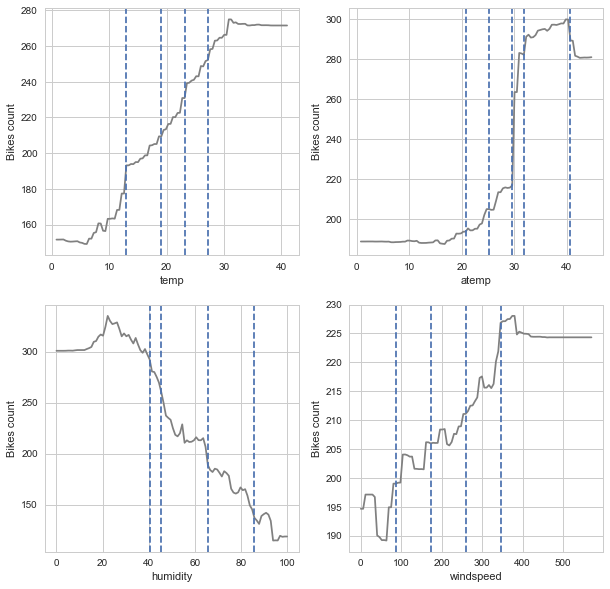

In [415]:
pelt_breaks_rf = {}
plt.figure(figsize=(10, 10))
for i, var in enumerate(numeric_vars):
    pelt_breaks_rf[X_train.columns[var]] = pdp_and_pelt(pipe_rf, X_train.columns[var], X_train, 100, rpt_pen=1, subplot = (2, 2, i+1))

Oprócz prędkości wiatru, dla wszystkich zmiennych profile PDP zachowują się jak trend liniowy dla wykresów rozrzutu, co do monotoniczności.

### Model białej skrzynki po transformacji SAFE dla lasu losowego

In [416]:
X_train_safe_rf = X_train.copy(deep=True)

cat_replace_dict = {}
for var in X_train_safe_rf.columns[multicat_vars]:
    cat_replace_dict[var] = safe_clust(pipe_rf, var, X_train_safe_rf, 2)
X_train_safe_rf = X_train_safe_rf.replace(cat_replace_dict)

for var, breaks in pelt_breaks_rf.items():
    X_train_safe_rf[var] = pd.cut(X_train_safe_rf[var], breaks)

Sprawdźmy, czy dobrze zadziałało i mamy odpowiednio mało kategorii.

In [417]:
X_train_safe_rf.nunique()

season        2
holiday       2
workingday    2
weather       2
temp          5
atemp         6
humidity      5
windspeed     5
dayOfWeek     2
dtype: int64

In [419]:
ohe_safe_rf = OneHotEncoder()
lr_safe_rf = LinearRegression()

pipe_lr_safe_rf = Pipeline([
    ('ohe_s_rf', ohe_safe_rf),
    ('lr_s_rf', lr_safe_rf)
])

_ = pipe_lr_safe_rf.fit(X_train_safe_rf, y_train)

Trzeba jeszcze przekształcić zbiór testowy.

In [439]:
X_test_safe_rf = X_test.copy(deep=True)

cat_replace_dict = {}
for var in X_test_safe_rf.columns[multicat_vars]:
    cat_replace_dict[var] = safe_clust(pipe_rf, var, X_test_safe_rf, 2)
X_test_safe_rf = X_test_safe_rf.replace(cat_replace_dict)

for var, breaks in pelt_breaks_rf.items():
    X_test_safe_rf.loc[X_test_safe_rf[var] <= breaks[0], var] = breaks[0]
    X_test_safe_rf.loc[X_test_safe_rf[var] >= breaks[-1], var] = breaks[-1]
    X_test_safe_rf[var] = pd.cut(X_test_safe_rf[var], breaks)

### Elastyczny model czarnej skrzynki - Multi-layer Perceptron

In [234]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_vars),
    ('scale', StandardScaler(), numeric_vars)
])
mlp = MLPRegressor(learning_rate_init=0.1, max_iter=300)

pipe_mlp = Pipeline([
    ('ct', ct),
    ('mlp', mlp)
])

_ = pipe_mlp.fit(X_train, y_train)

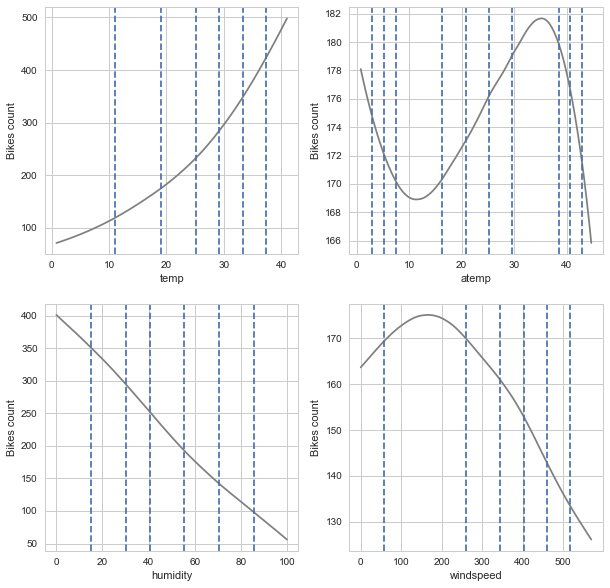

In [420]:
pelt_breaks_mlp = {}
plt.figure(figsize=(10, 10))
for i, var in enumerate(numeric_vars):
    pelt_breaks_mlp[X_train.columns[var]] = pdp_and_pelt(pipe_mlp, X_train.columns[var], X_train, 100, rpt_pen=1, subplot = (2, 2, i+1))

Znowu profile PDP ukazują podobny trend, co dopasowane funkcje liniowe na wykresach rozrzutu. Wyjątkiem znowu jest prędkość wiatru, chociaż tutaj widać nieliniową zależność, która była też wyraźna dla lasu losowego.

### Model białej skrzynki po transformacji SAFE dla lasu losowego

In [421]:
X_train_safe_mlp = X_train.copy(deep=True)

cat_replace_dict = {}
for var in X_train_safe_mlp.columns[multicat_vars]:
    cat_replace_dict[var] = safe_clust(pipe_mlp, var, X_train_safe_mlp, 2)
X_train_safe_mlp = X_train_safe_mlp.replace(cat_replace_dict)

for var, breaks in pelt_breaks_mlp.items():
    X_train_safe_mlp[var] = pd.cut(X_train_safe_mlp[var], breaks)

In [423]:
ohe_safe_mlp = OneHotEncoder()
lr_safe_mlp = LinearRegression()

pipe_lr_safe_mlp = Pipeline([
    ('ohe_s_mlp', ohe_safe_mlp),
    ('lr_s_mlp', lr_safe_mlp)
])

_ = pipe_lr_safe_mlp.fit(X_train_safe_mlp, y_train)

In [440]:
X_test_safe_mlp = X_test.copy(deep=True)

cat_replace_dict = {}
for var in X_test_safe_mlp.columns[multicat_vars]:
    cat_replace_dict[var] = safe_clust(pipe_mlp, var, X_test_safe_mlp, 2)
X_test_safe_mlp = X_test_safe_mlp.replace(cat_replace_dict)

for var, breaks in pelt_breaks_mlp.items():
    X_test_safe_mlp.loc[X_test_safe_mlp[var] <= breaks[0], var] = breaks[0]
    X_test_safe_mlp.loc[X_test_safe_mlp[var] >= breaks[-1], var] = breaks[-1]
    X_test_safe_mlp[var] = pd.cut(X_test_safe_mlp[var], breaks)

In [437]:
X_test_safe_mlp.apply(lambda x: sum(x.isna()))

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         1
humidity      0
windspeed     0
dayOfWeek     0
dtype: int64

## Porównanie modeli

Mamy do czynienia z problemem regresyjnym, więc do porównania modeli wykorzystałem krzywe REC. Najpierw porównuję elastyczne modele między sobą. Następnie dla każdego z wybranych elastycznych modeli przedstawiam krzywą dla danego modelu, dla modelu białoskrzynkowego oraz dla tego modelu po użyciu metody SAFE.

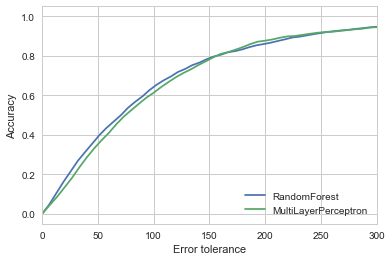

In [435]:
rec([('RandomForest', pipe_rf, X_test), ('MultiLayerPerceptron', pipe_mlp, X_test)], y_test, 100, 300)

Zgodnie z powyższym wykresem las losowy radzi sobie minimalnie lepiej, z wyjątkiem zakresu wyższej tolerancji.

### Las losowy

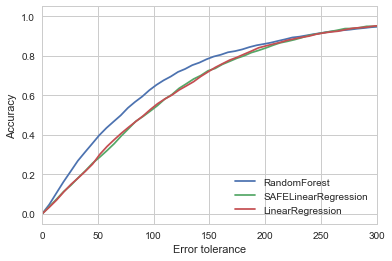

In [442]:
rec([('RandomForest', pipe_rf, X_test), ('SAFELinearRegression', pipe_lr_safe_rf, X_test_safe_rf), ('LinearRegression', pipe_lr, X_test)], y_test, 100, 300)

W przypadku lasu losowego model stworzony przy użyciu SAFE daje predykcje bardzo podobnej jakości co zwykła regresja liniowa. Nadal jest to dość zadowalający wynik, ponieważ ilość kategorii została dość mocno ograniczona, a mimo wszystko udało się wyekstrahować na tyle dużo zależności znalezionych przez elastyczny model, żeby zachować moc predykcyjną.

### Multi-layer Perceptron

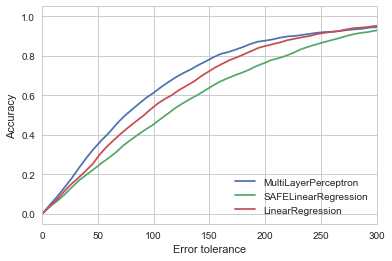

In [443]:
rec([('MultiLayerPerceptron', pipe_mlp, X_test), ('SAFELinearRegression', pipe_lr_safe_mlp, X_test_safe_mlp), ('LinearRegression', pipe_lr, X_test)], y_test, 100, 300)

W przypadku perceptronu model SAFE poradził sobie zdecydowanie najgorzej. Dla zmiennych ciągłych można tłumaczyć to tym, że o profile PDP dla lasu losowego posiadały wiele "wypłaszczeń", gdzie lokalnie stały model mógł się sprawdzić, o tyle w sieci neuronowej wyraźne były monotoniczne zależności, 